Note: this tutorial only works on CPU.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

def get_entropy(x, k=1, th=1e-2):
    n = x.shape[0] # the number of data points
    d = x.shape[1] # dimension
    
    Vd = torch.pi**(d/2)/torch.tensor(1+d/2).lgamma().exp()
    gamma = 0.577216
    Psi = -gamma + torch.sum(1/torch.tensor([i for i in range(1,k)]))
    H_const = torch.log(Vd) + torch.log(torch.tensor(n-1)) - Psi
        
    dist = torch.linalg.norm(x[None,:,:] - x[:,None,:], dim=2)
    rho = torch.sort(dist, dim=1).values[:,k]

    H_rho = d * torch.mean(torch.log(rho+th))
    H_total = H_rho + H_const
    return H_total

def get_entropy_with_labels(x, labels, k=1, th=1e-2):
    n_class = len(set(list(labels.numpy())))
    
    entropy = 0.
    for i in range(n_class):
        member = torch.where(labels == i)[0]
        entropy_i = get_entropy(x[member])
        entropy += entropy_i
        
    return entropy

Example 1: Gaussian

In [2]:
set_seed()

# try Guassian first

n = 100 # the number of data points
d = 3 # dimension
x = torch.randn(n, d)
H_total = get_entropy(x)
H_total_true = (1/2 * torch.log(torch.tensor(2*torch.pi)) + 1/2)*d
print(f'true entropy: {H_total_true}, estimated entropy: {H_total}')

true entropy: 4.256815433502197, estimated entropy: 4.171512603759766


Example 2: Nice cluster structures in low-dimensional subspace, but extra dimensions are random

Text(0.5, 1.0, 'Random projection: entropy=2.255')

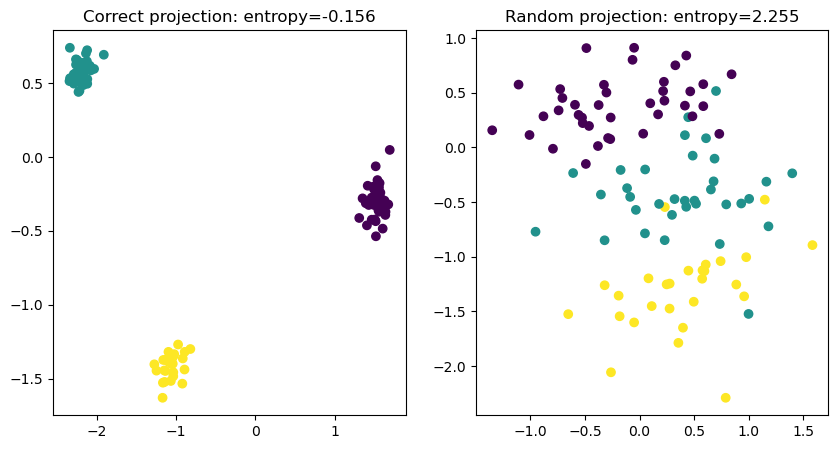

In [3]:
set_seed()

n = 100
d_structure = 2
d_random = 8
d = d_structure + d_random
n_class = 3
sigma_inter_cluster = 1.
sigma_intra_cluster = 0.1
sigma_random = 0.5

cluster_centers = torch.randn(n_class, d_structure) * sigma_inter_cluster
labels = torch.from_numpy(np.random.choice(n_class, n)).long()

x_structure = cluster_centers[labels] + torch.randn(n, d_structure) * sigma_intra_cluster
x_random = torch.randn(n, d_random) * sigma_random
x = torch.cat([x_structure, x_random], dim=1)

A = torch.randn(d,d)
U, S, V = torch.svd(A)
x_random = torch.matmul(x, U)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1], c=labels)
entropy = get_entropy(x[:,:2])
plt.title('Correct projection: entropy=%.3f'%entropy)

plt.subplot(1,2,2)
# random projection
plt.scatter(x_random[:,0], x_random[:,1], c=labels)
entropy_random = get_entropy(x_random[:,:2])
plt.title('Random projection: entropy=%.3f'%entropy_random)

Optimize with get_entropy. This is the unsupervised setting where we don't know the labels. The results are fine but I find them not to be very stable.

step=0, entropy=2.096


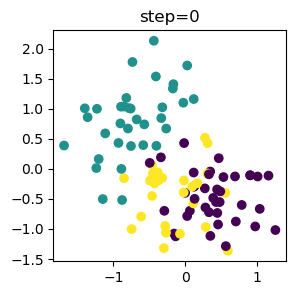

step=100, entropy=1.550
step=200, entropy=1.525
step=300, entropy=1.765
step=400, entropy=1.668
step=500, entropy=1.351
step=600, entropy=1.257
step=700, entropy=0.888
step=800, entropy=0.490
step=900, entropy=0.561
step=1000, entropy=0.640
step=1100, entropy=0.673
step=1200, entropy=0.436
step=1300, entropy=0.504
step=1400, entropy=0.447
step=1500, entropy=0.526
step=1600, entropy=0.810
step=1700, entropy=0.462
step=1800, entropy=0.715
step=1900, entropy=0.493


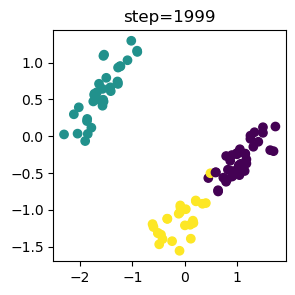

In [4]:
# make A trainable


set_seed(1)

n_steps = 2000
log = 100
A = torch.nn.Linear(d_structure, d)

cheat = False
if cheat:
    W = torch.zeros(d, d_structure)
    for i in range(d_structure):
        W[i,i] = 1.
    A.weight.data = W

U = torch.nn.utils.parametrizations.orthogonal(A)
optimizer = torch.optim.SGD(A.parameters(), lr=1e-3)

for i in range(n_steps):
    
    optimizer.zero_grad()
    x_proj = torch.matmul(x, U.weight)
    entropy = get_entropy(x_proj)
    entropy.backward()
    optimizer.step()
    
    if i % log == 0:
        print('step=%d, entropy=%.3f'%(i, entropy))
        
    if i == 0 or i == n_steps-1:
        
        x_proj = torch.matmul(x, U.weight)
        x_proj = x_proj.detach().numpy()
        plt.figure(figsize=(3,3))
        plt.scatter(x_proj[:,0], x_proj[:,[1]], c=labels)
        plt.title(f'step={i}')
        plt.show()

Optimize with get_entropy_with_labels. This is the supervised setting where we know the labels. The results are really nice.

step=0, entropy=4.000


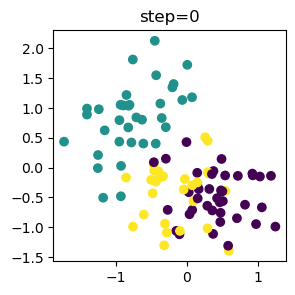

step=100, entropy=-0.638
step=200, entropy=-0.841
step=300, entropy=-1.608
step=400, entropy=-2.556
step=500, entropy=-3.016
step=600, entropy=-3.506
step=700, entropy=-3.117
step=800, entropy=-3.526
step=900, entropy=-4.052
step=1000, entropy=-3.443
step=1100, entropy=-3.142
step=1200, entropy=-3.704
step=1300, entropy=-3.383
step=1400, entropy=-2.973
step=1500, entropy=-2.697
step=1600, entropy=-2.730
step=1700, entropy=-2.811
step=1800, entropy=-2.825
step=1900, entropy=-3.693


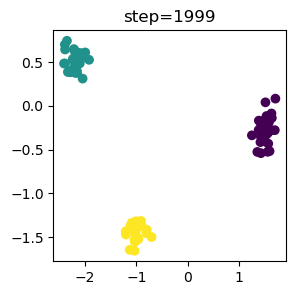

In [5]:
# make A trainable


set_seed(1)

n_steps = 2000
log = 100
A = torch.nn.Linear(d_structure, d)

cheat = False
if cheat:
    W = torch.zeros(d, d_structure)
    for i in range(d_structure):
        W[i,i] = 1.
    A.weight.data = W

U = torch.nn.utils.parametrizations.orthogonal(A)
optimizer = torch.optim.SGD(A.parameters(), lr=1e-3)

for i in range(n_steps):
    
    optimizer.zero_grad()
    x_proj = torch.matmul(x, U.weight)
    entropy = get_entropy_with_labels(x_proj, labels)
    entropy.backward()
    optimizer.step()
    
    if i % log == 0:
        print('step=%d, entropy=%.3f'%(i, entropy))
        
    if i == 0 or i == n_steps-1:
        
        x_proj = torch.matmul(x, U.weight)
        x_proj = x_proj.detach().numpy()
        plt.figure(figsize=(3,3))
        plt.scatter(x_proj[:,0], x_proj[:,[1]], c=labels)
        plt.title(f'step={i}')
        plt.show()